# **Project Setup**

Create a new Django project named tutorial, then start a new app called quickstart.

In [ ]:
# Create the project directory
mkdir tutorial
cd tutorial

# Create a virtual environment to isolate our package dependencies locally
python3 -m venv env
source env/bin/activate  # On Windows use `env\Scripts\activate`

# Install Django and Django REST framework into the virtual environment
pip install django
pip install djangorestframework

# Set up a new project with a single application
django-admin startproject tutorial .  # Note the trailing '.' character
cd tutorial
django-admin startapp quickstart
cd ..

The project layout should look like:

In [ ]:
$ pwd
<some path>/tutorial
$ find .
.
./manage.py
./tutorial
./tutorial/__init__.py
./tutorial/quickstart
./tutorial/quickstart/__init__.py
./tutorial/quickstart/admin.py
./tutorial/quickstart/apps.py
./tutorial/quickstart/migrations
./tutorial/quickstart/migrations/__init__.py
./tutorial/quickstart/models.py
./tutorial/quickstart/tests.py
./tutorial/quickstart/views.py
./tutorial/asgi.py
./tutorial/settings.py
./tutorial/urls.py
./tutorial/wsgi.py

It may look unusual that the application has been created within the project directory. Using the project's namespace avoids name clashes with external modules (a topic that goes outside the scope of the quickstart).

Now sync your database for the first time:

In [ ]:
python manage.py migrate

We'll also create an initial user named admin with a password of password123. We'll authenticate as that user later in our example

In [ ]:
python manage.py createsuperuser --email admin@example.com --username admin

Once you've set up a database and the initial user is created and ready to go, open up the app's directory and we'll get coding...

# **Serializers**

First up we're going to define some serializers. Let's create a new module named tutorial/quickstart/serializers.py that we'll use for our data representations

In [ ]:
from django.contrib.auth.models import User, Group
from rest_framework import serializers


class UserSerializer(serializers.HyperlinkedModelSerializer):
    class Meta:
        model = User
        fields = ['url', 'username', 'email', 'groups']


class GroupSerializer(serializers.HyperlinkedModelSerializer):
    class Meta:
        model = Group
        fields = ['url', 'name']

Notice that we're using hyperlinked relations in this case with HyperlinkedModelSerializer. You can also use primary key and various other relationships, but hyperlinking is good RESTful design.

# **Views**

Right, we'd better write some views then. Open tutorial/quickstart/views.py and get typing.

In [ ]:
from django.contrib.auth.models import User, Group
from rest_framework import viewsets
from rest_framework import permissions
from tutorial.quickstart.serializers import UserSerializer, GroupSerializer


class UserViewSet(viewsets.ModelViewSet):
    """
    API endpoint that allows users to be viewed or edited.
    """
    queryset = User.objects.all().order_by('-date_joined')
    serializer_class = UserSerializer
    permission_classes = [permissions.IsAuthenticated]


class GroupViewSet(viewsets.ModelViewSet):
    """
    API endpoint that allows groups to be viewed or edited.
    """
    queryset = Group.objects.all()
    serializer_class = GroupSerializer
    permission_classes = [permissions.IsAuthenticated]

Rather than write multiple views we're grouping together all the common behavior into classes called ViewSets.

We can easily break these down into individual views if we need to, but using viewsets keeps the view logic nicely organized as well as being very concise.

# **URL's**

Okay, now let's wire up the API URLs. On to tutorial/urls.py..

In [ ]:
from django.urls import include, path
from rest_framework import routers
from tutorial.quickstart import views

router = routers.DefaultRouter()
router.register(r'users', views.UserViewSet)
router.register(r'groups', views.GroupViewSet)

# Wire up our API using automatic URL routing.
# Additionally, we include login URLs for the browsable API.
urlpatterns = [
    path('', include(router.urls)),
    path('api-auth/', include('rest_framework.urls', namespace='rest_framework'))
]

Because we're using viewsets instead of views, we can automatically generate the URL conf for our API, by simply registering the viewsets with a router class.

Again, if we need more control over the API URLs we can simply drop down to using regular class-based views, and writing the URL conf explicitly.

Finally, we're including default login and logout views for use with the browsable API. That's optional, but useful if your API requires authentication and you want to use the browsable API.

# **Pagination**

Pagination allows you to control how many objects per page are returned. To enable it add the following lines to tutorial/settings.py

In [ ]:
REST_FRAMEWORK = {
    'DEFAULT_PAGINATION_CLASS': 'rest_framework.pagination.PageNumberPagination',
    'PAGE_SIZE': 10
}

# **Settings**

Add 'rest_framework' to INSTALLED_APPS. The settings module will be in tutorial/settings.py

In [ ]:
INSTALLED_APPS = [
    ...
    'rest_framework',
]

Okay, we're done.

# **Testing our API**

We're now ready to test the API we've built. Let's fire up the server from the command line

In [ ]:
python manage.py runserver

We can now access our API, both from the command-line, using tools like curl...

In [ ]:
bash: curl -H 'Accept: application/json; indent=4' -u admin:password123 http://127.0.0.1:8000/users/
{
    "count": 2,
    "next": null,
    "previous": null,
    "results": [
        {
            "email": "admin@example.com",
            "groups": [],
            "url": "http://127.0.0.1:8000/users/1/",
            "username": "admin"
        },
    ]
}

Or using the httpie, command line tool..

In [ ]:
bash: http -a admin:password123 http://127.0.0.1:8000/users/

HTTP/1.1 200 OK
...
{
    "count": 2,
    "next": null,
    "previous": null,
    "results": [
        {
            "email": "admin@example.com",
            "groups": [],
            "url": "http://localhost:8000/users/1/",
            "username": "paul"
        },
    ]
}

Or directly through the browser, by going to the URL http://127.0.0.1:8000/users/...

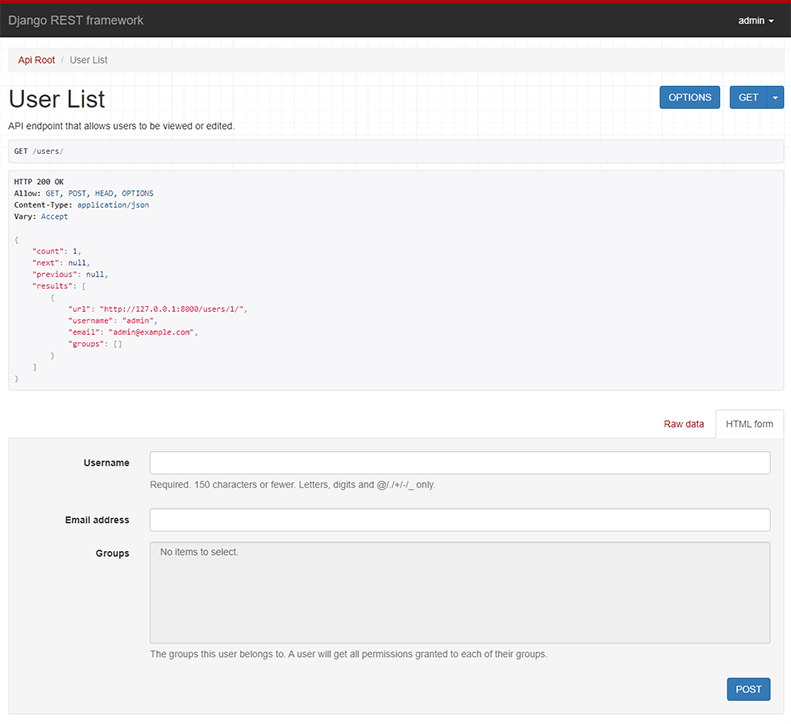

If you're working through the browser, make sure to login using the control in the top right corner.